In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u

import sys
sys.path.append("../exonamd")
from core import compute_namd
from core import namd_loop
from core import amd
from core import namd

pd.options.display.max_columns = 20
pd.options.display.max_rows = 30
pd.options.mode.copy_on_write = True
import warnings
warnings.filterwarnings("ignore")

Load from here ->

In [2]:
df = pd.read_csv("data.csv")
df.index = df["Unnamed: 0"].values
# drop the Unnamed: 0 column
df = df.drop(columns=["Unnamed: 0"])

# df[df["pl_trueobliq"].notnull()][["pl_name", "pl_trueobliq", "pl_trueobliqerr1", "pl_trueobliqerr2"]]

add_index = df.index.max() + 1
df.loc[add_index, 'pl_name'] = 'K2-290 b'
df.loc[add_index, 'hostname'] = 'K2-290'
df.loc[add_index, 'default_flag'] = 1

df.loc[add_index, 'pl_orbsmax'] = 0.0923
df.loc[add_index, 'pl_orbsmaxerr1'] = 0.0
df.loc[add_index, 'pl_orbsmaxerr2'] = 0.0

df.loc[add_index, 'pl_orbincl'] = 88.2
df.loc[add_index, 'pl_orbinclerr1'] = 0.5
df.loc[add_index, 'pl_orbinclerr2'] = -0.6

df.loc[add_index, 'pl_bmasse'] = 10.9041861
df.loc[add_index, 'pl_bmasseerr1'] = 0.0
df.loc[add_index, 'pl_bmasseerr2'] = 0.0

df.loc[add_index, 'pl_trueobliq'] = 127.0
df.loc[add_index, 'pl_trueobliqerr1'] = 0.0
df.loc[add_index, 'pl_trueobliqerr2'] = 0.0

df.loc[add_index, 'sy_pnum'] = 2
df.loc[add_index, 'pl_orbeccen'] = 0.0
df.loc[add_index, 'pl_orbeccenerr1'] = 0.0
df.loc[add_index, 'pl_orbeccenerr2'] = 0.0

df.loc[add_index, 'flag'] = "0"


# adjust the masses of the TOI-942 system planets
idx_toi942b = df[df["pl_name"] == "TOI-942 b"].index[0]
idx_toi942c = df[df["pl_name"] == "TOI-942 c"].index[0]

df.loc[idx_toi942b, "pl_bmasse"] = 16.0
df.loc[idx_toi942c, "pl_bmasse"] = 32.0

# adjust the inclinations of the Kepler-9 system planets

# remove idx 710
df = df.drop(710)

# K2-290
idx_k2290b = df[df["pl_name"] == "K2-290 b"].index[0]
df.loc[idx_k2290b, "pl_trueobliqerr1"] = 42.0
df.loc[idx_k2290b, "pl_trueobliqerr2"] = -50.0

# Kepler-462
idx_k462b = df[df["pl_name"] == "Kepler-462 b"].index[0]
df.loc[idx_k462b, "pl_orbincl"] = 89.340
df.loc[idx_k462b, "pl_orbinclerr1"] = 0.05
df.loc[idx_k462b, "pl_orbinclerr2"] = -0.05
df.loc[idx_k462b, "pl_orbeccen"] = 0.056
df.loc[idx_k462b, "pl_orbeccenerr1"] = 0.019
df.loc[idx_k462b, "pl_orbeccenerr2"] = -0.019

idx_k462c = df[df["pl_name"] == "Kepler-462 c"].index[0]
df.loc[idx_k462c, "pl_orbincl"] = 90.64
df.loc[idx_k462c, "pl_orbinclerr1"] = 0.06
df.loc[idx_k462c, "pl_orbinclerr2"] = -0.06
df.loc[idx_k462c, "pl_orbeccen"] = 0.50
df.loc[idx_k462c, "pl_orbeccenerr1"] = 0.09
df.loc[idx_k462c, "pl_orbeccenerr2"] = -0.09

# Kepler-9
idx_k9b = df[df["pl_name"] == "Kepler-9 b"].index[0]

In [3]:
df.columns

Index(['pl_name', 'hostname', 'default_flag', 'pl_orbsmax', 'pl_orbsmaxerr1',
       'pl_orbsmaxerr2', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2',
       'sy_pnum', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2',
       'pl_orbincl', 'pl_orbinclerr1', 'pl_orbinclerr2', 'pl_trueobliq',
       'pl_trueobliqerr1', 'pl_trueobliqerr2', 'flag'],
      dtype='object')

In [4]:
rm_hostnames = []

for hostname in df["hostname"].unique():
    df_host = df[df["hostname"] == hostname]
    # # if df_host contains NaN values, save hostname to a list
    # if df_host.isnull().values.any():
    #     # print(df_host)
    #     rm_hostnames.append(hostname)
    # if df_host contains NaN values in columns different than pl_trueobliq, save hostname to a list
    if df_host.drop(columns=["pl_trueobliq", "pl_trueobliqerr1", "pl_trueobliqerr2"]).isnull().values.any():
        rm_hostnames.append(hostname)

# len(rm_hostnames)
df_clean = df[~df["hostname"].isin(rm_hostnames)]

# remove one hostname which has wrong values in the database ad hoc
df_clean = df_clean[df_clean["hostname"] != "HD 20782"]

# sort the DataFrame by the hostname
df_clean = df_clean.sort_values(by="hostname")

In [5]:
df_clean_stored = df_clean.copy()

In [6]:
maxmass_plnames = []
trueoblmm_hostnames = []

for hostname in df_clean["hostname"].unique():
    df_host = df_clean[df_clean["hostname"] == hostname]
    
    # take the planet with maximum mass
    maxmass_pl = df_host["pl_bmasse"].idxmax()
    maxmass_plnames.append(hostname)

    # if the obliquity is null for all planets, do this:
    if df_host["pl_trueobliq"].isnull().all():

        df_clean.loc[df_host.index, "pl_relincl"] = \
            df_host.loc[maxmass_pl, "pl_orbincl"] - df_host["pl_orbincl"]
        
        df_clean.loc[df_host.index, "pl_relinclerr1"] = \
            np.sqrt(df_host.loc[maxmass_pl, "pl_orbinclerr1"]**2 + df_host["pl_orbinclerr1"]**2)
        
        df_clean.loc[df_host.index, "pl_relinclerr2"] = \
            np.sqrt(df_host.loc[maxmass_pl, "pl_orbinclerr2"]**2 + df_host["pl_orbinclerr2"]**2)
    elif df_host["pl_trueobliq"].notnull().all():
        # assume the relative inclination is equal to the true obliquity

        df_clean.loc[df_host.index, "pl_relincl"] = df_host["pl_trueobliq"]
        df_clean.loc[df_host.index, "pl_relinclerr1"] = df_host["pl_trueobliqerr1"]
        df_clean.loc[df_host.index, "pl_relinclerr2"] = df_host["pl_trueobliqerr2"]

    # else if we have the obliquity for the most massive planet, we assume that all the planets have the same obliquity
    elif ~np.isnan(df_host.loc[maxmass_pl, "pl_trueobliq"]):
        df_clean.loc[df_host.index, "pl_relincl"] = df_host.loc[maxmass_pl, "pl_trueobliq"]
        df_clean.loc[df_host.index, "pl_relinclerr1"] = df_host.loc[maxmass_pl, "pl_trueobliqerr1"]
        df_clean.loc[df_host.index, "pl_relinclerr2"] = df_host.loc[maxmass_pl, "pl_trueobliqerr2"]

        trueoblmm_hostnames.append(hostname)

    else:
        print("We should not be here: ", hostname)
        continue

df_clean = df_clean.drop(479)

for hostname in df_clean["hostname"].unique():
    df_host = df_clean[df_clean["hostname"] == hostname]
    
    # calculate the AMD
    amd_val = amd(
        df_host["pl_bmasse"], 
        df_host["pl_orbeccen"], 
        df_host["pl_relincl"], 
        df_host["pl_orbsmax"])
    
    df_clean.loc[df_host.index, "amd"] = amd_val

    # calculate the NAMD
    namd_val = namd(amd_val, df_host["pl_bmasse"], df_host["pl_orbsmax"])

    df_clean.loc[df_host.index, "namd"] = namd_val

df_clean_obliquity = df_clean.copy()

We should not be here:  HAT-P-11
We should not be here:  Kepler-25
We should not be here:  TOI-942
We should not be here:  V1298 Tau


In [7]:
df_clean_obliquity[df_clean_obliquity["pl_trueobliq"].notnull()][["pl_name", "pl_trueobliq", "pl_relincl"]]

,pl_name,pl_trueobliq,pl_relincl
1179,HAT-P-11 b,106.0,NaN
16822,K2-290 b,127.0,127.0
1312,K2-290 c,124.0,124.0
4277,Kepler-25 c,26.9,NaN
3192,Kepler-462 b,72.0,72.0
1884,Kepler-9 b,28.1,28.1
3805,TOI-942 b,2.0,NaN
1813,V1298 Tau b,8.0,NaN
192,WASP-84 b,17.3,17.3


In [8]:
# trueoblmm_hostnames += ["TOI-942", "TOI-1136", "TOI-5398", "WASP-47", "WASP-84", "TOI-2076", "Kepler-25"]

In [9]:
trueoblmm_hostnames

['Kepler-462', 'Kepler-9', 'WASP-84']

Note: we can fill manually all the missing values

Note: we have both obl for Kepler-462 and K2-290

In [10]:
df_clean_obliquity[df_clean_obliquity["hostname"] == "K2-290"][["pl_name", "pl_relincl", "amd", "namd"]]

,pl_name,pl_relincl,amd,namd
16822,K2-290 b,127.0,5.306479,1.560207
1312,K2-290 c,124.0,211.829098,1.560207


In [11]:
df_clean_obliquity[df_clean_obliquity["pl_trueobliq"].notnull()][["pl_name", "pl_bmasse", "pl_relincl", "pl_trueobliq", "amd", "namd"]]

,pl_name,pl_bmasse,pl_relincl,pl_trueobliq,amd,namd
1179,HAT-P-11 b,25.743000,NaN,106.0,NaN,0.000000
16822,K2-290 b,10.904186,127.0,127.0,5.306479,1.560207
1312,K2-290 c,246.000420,124.0,124.0,211.829098,1.560207
4277,Kepler-25 c,24.065460,NaN,26.9,NaN,0.000000
3192,Kepler-462 b,53.900000,72.0,72.0,25.635234,0.696807
1884,Kepler-9 b,43.541000,28.1,28.1,1.936046,0.117873
3805,TOI-942 b,16.000000,NaN,2.0,NaN,0.000000
1813,V1298 Tau b,203.410180,NaN,8.0,NaN,0.000000
192,WASP-84 b,220.282500,17.3,17.3,2.770669,0.046974


In [12]:
df_clean = df_clean_stored.copy()

In [13]:
maxmass_plnames = []

for hostname in df_clean["hostname"].unique():
    df_host = df_clean[df_clean["hostname"] == hostname]
    
    # take the planet with maximum mass
    maxmass_pl = df_host["pl_bmasse"].idxmax()
    maxmass_plnames.append(hostname)

    df_clean.loc[df_host.index, "pl_relincl"] = \
        df_host.loc[maxmass_pl, "pl_orbincl"] - df_host["pl_orbincl"]
    
    df_clean.loc[df_host.index, "pl_relinclerr1"] = \
        np.sqrt(df_host.loc[maxmass_pl, "pl_orbinclerr1"]**2 + df_host["pl_orbinclerr1"]**2)
    
    df_clean.loc[df_host.index, "pl_relinclerr2"] = \
        np.sqrt(df_host.loc[maxmass_pl, "pl_orbinclerr2"]**2 + df_host["pl_orbinclerr2"]**2)

df_clean = df_clean.drop(479)

for hostname in df_clean["hostname"].unique():
    df_host = df_clean[df_clean["hostname"] == hostname]
    
    # calculate the AMD
    amd_val = amd(
        df_host["pl_bmasse"], 
        df_host["pl_orbeccen"], 
        df_host["pl_relincl"], 
        df_host["pl_orbsmax"])
    
    df_clean.loc[df_host.index, "amd"] = amd_val

    # calculate the NAMD
    namd_val = namd(amd_val, df_host["pl_bmasse"], df_host["pl_orbsmax"])

    df_clean.loc[df_host.index, "namd"] = namd_val

df_clean_relincl = df_clean.copy()

In [14]:
df_clean_relincl[df_clean_relincl["hostname"] == "WASP-84"][["pl_name", "pl_relincl", "amd", "namd"]]

,pl_name,pl_relincl,amd,namd
1724,WASP-84 c,5.168,0.124535,0.001959
192,WASP-84 b,0.000,0.000000,0.001959


In [15]:
df_clean_relincl[df_clean_relincl["pl_trueobliq"].notnull()][["pl_name", "pl_bmasse", "pl_relincl", "pl_trueobliq", "amd", "namd"]]

,pl_name,pl_bmasse,pl_relincl,pl_trueobliq,amd,namd
1179,HAT-P-11 b,25.743000,45.8800,106.0,1.820951,0.202375
16822,K2-290 b,10.904186,1.1700,127.0,0.000691,0.000005
1312,K2-290 c,246.000420,0.0000,124.0,0.000000,0.000005
4277,Kepler-25 c,24.065460,0.0500,26.9,0.000003,0.001721
3192,Kepler-462 b,53.900000,0.0000,72.0,0.058177,0.018877
1884,Kepler-9 b,43.541000,0.0000,28.1,0.000000,0.000000
3805,TOI-942 b,16.000000,-0.7660,2.0,0.146677,0.022573
1813,V1298 Tau b,203.410180,0.3205,8.0,0.755001,0.040479
192,WASP-84 b,220.282500,0.0000,17.3,0.000000,0.001959


In [16]:
# drop columns with trueobliq from df_clean_relincl
trueobliq_notnull = df_clean_relincl["pl_trueobliq"].notnull()

df_clean_relincl = df_clean_relincl.drop(columns=["pl_trueobliq", "pl_trueobliqerr1", "pl_trueobliqerr2"])

In [17]:
# drop nans from df_clean_relincl
df_clean_relincl = df_clean_relincl.dropna()

In [18]:
df_clean_relincl

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,...,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,flag,pl_relincl,pl_relinclerr1,pl_relinclerr2,amd,namd
10061,24 Sex b,24 Sex,1.0,1.333000,0.00400,-0.00900,632.460000,82.630000,-120.770000,2.0,...,-0.0600,90.0,0.0,0.0,03,0.0,0.0,0.0,2.963366,0.017701
10041,24 Sex c,24 Sex,1.0,2.080000,0.05000,-0.02000,273.320000,111.240000,-69.920000,2.0,...,-0.0900,90.0,0.0,0.0,03,0.0,0.0,0.0,16.939568,0.017701
10100,47 UMa c,47 UMa,1.0,3.600000,0.10000,-0.10000,171.621000,20.976000,-23.201000,3.0,...,-0.0940,90.0,0.0,0.0,03,0.0,0.0,0.0,1.567438,0.020892
9798,47 UMa d,47 UMa,1.0,12.700000,3.45000,-2.50000,500.570445,81.046125,-103.290415,3.0,...,-0.1550,90.0,0.0,0.0,03,0.0,0.0,0.0,66.252946,0.020892
6293,47 UMa b,47 UMa,1.0,2.100000,0.02650,-0.02700,804.080000,31.780000,-31.780000,3.0,...,-0.0140,90.0,0.0,0.0,03,0.0,0.0,0.0,0.596747,0.020892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5144,tau Cet h,tau Cet,1.0,0.243000,0.00300,-0.00300,1.830000,0.680000,-0.260000,4.0,...,-0.1500,90.0,0.0,0.0,03,0.0,0.0,0.0,0.024185,0.014605
10110,tau Cet f,tau Cet,1.0,1.334000,0.01700,-0.04400,3.930000,1.050000,-1.370000,4.0,...,-0.1600,90.0,0.0,0.0,03,0.0,0.0,0.0,0.058477,0.014605
6813,ups And d,ups And,1.0,2.523500,0.02600,-0.02700,1307.867185,46.085000,-46.085000,3.0,...,-0.0145,90.0,0.0,0.0,03,0.0,0.0,0.0,84.016243,0.037780
2807,ups And c,ups And,1.0,0.828387,0.01000,-0.01000,629.437500,23.835000,-23.835000,3.0,...,-0.0140,90.0,0.0,0.0,03,0.0,0.0,0.0,18.117679,0.037780


In [19]:
len(df_clean_relincl.hostname.unique())

836

In [20]:
df_clean_relincl_good = df_clean_relincl[df_clean_relincl["flag"].apply(lambda x: "0" in x)]
# and now only where the string elements are all "0"
df_clean_relincl_good = df_clean_relincl_good[df_clean_relincl_good["flag"].apply(lambda x: all([el == "0" for el in x]))]

len(df_clean_relincl_good.hostname.unique())

153

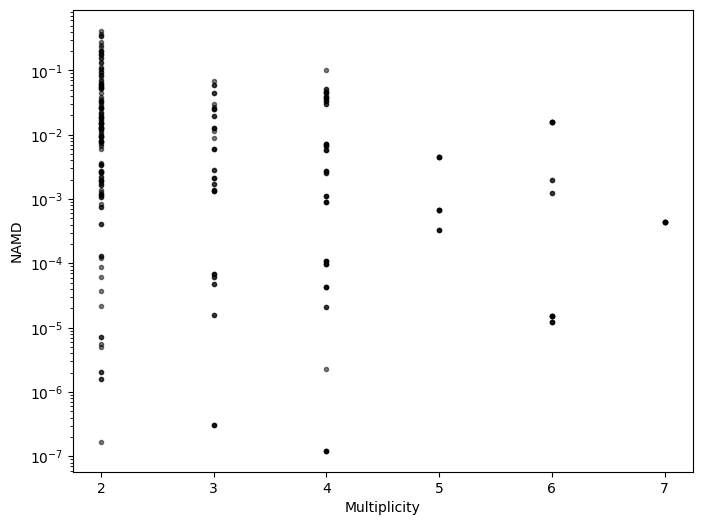

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(df_clean_relincl_good["sy_pnum"], df_clean_relincl_good["namd"], '.', c="k", alpha=0.5)
plt.yscale("log")
plt.xlabel("Multiplicity")
plt.ylabel("NAMD")
plt.show()

In [22]:
namd_relincl_good = namd_loop(df_clean_relincl_good)

namd_relincl_good

50


,hostname,namd,namd_err1,namd_err2,N,flag,relative_uncertainty
1,BD-210397,0.038931,0.033019,0.02206,2.0,0,0.707398
2,CoRoT-20,0.182254,0.010711,0.010204,2.0,0,0.057379
5,GJ 2030,0.001416,0.001708,0.00054,2.0,0,0.794053
7,GJ 676 A,0.0533,0.013682,0.011377,4.0,"[0, 0]",0.235075
8,GJ 876,0.007506,0.000305,0.000221,4.0,"[0, 0, 0, 0]",0.034994
...,...,...,...,...,...,...,...
145,V1298 Tau,0.043377,0.026057,0.019146,4.0,"[0, 0]",0.521049
147,WASP-148,0.066025,0.018505,0.015505,2.0,"[0, 0]",0.257553
150,WASP-8,0.048178,0.001061,0.001042,2.0,0,0.021826
151,bet Pic,0.01665,0.005916,0.004445,2.0,"[0, 0]",0.311151


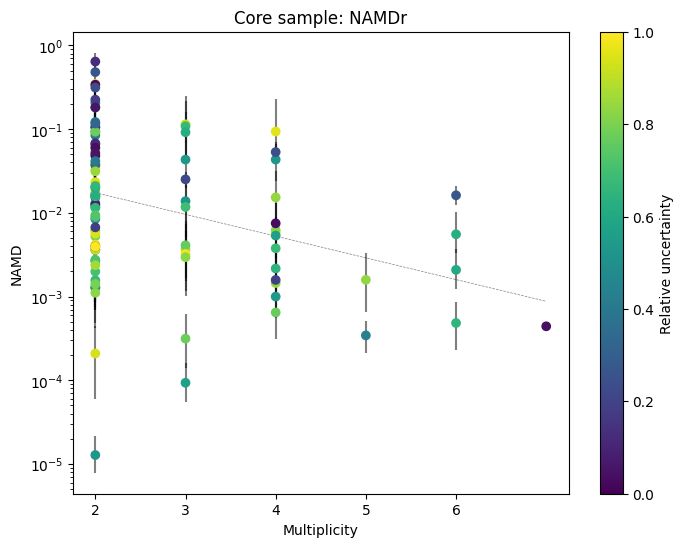

In [23]:
# plot the NAMD vs N and color by the relative uncertainty
namd_relincl_plot = namd_relincl_good.copy()
# sort columns by multiplicity
namd_relincl_plot = namd_relincl_plot.sort_values(by="N")
namd_relincl_plot.drop(columns=["flag", "hostname"], inplace=True)
# make the whole DataFrame numeric
namd_relincl_plot = namd_relincl_plot.apply(pd.to_numeric)

# plot the NAMD vs N and color by the relative uncertainty
plt.figure(figsize=(8, 6))
plt.errorbar(namd_relincl_plot["N"], namd_relincl_plot["namd"], 
             yerr=[namd_relincl_plot["namd_err2"], namd_relincl_plot["namd_err1"]], 
             fmt="none", c="k", alpha=0.5)
s = plt.scatter(namd_relincl_plot["N"], namd_relincl_plot["namd"], c=namd_relincl_plot["relative_uncertainty"], cmap="viridis", zorder=10)

coeffs = np.polyfit(namd_relincl_plot["N"], np.log10(namd_relincl_plot["namd"]), 1)
plt.plot(namd_relincl_plot["N"], 10 ** np.polyval(coeffs, namd_relincl_plot["N"]), 'k--', zorder=5, alpha=0.5, lw=0.5)

namd_err_avg = (namd_relincl_plot["namd_err1"] + namd_relincl_plot["namd_err2"]) / 2
# popt, pcov = np.polyfit(namd_relincl_plot["N"], np.log10(namd_relincl_plot["namd"]), 1, cov=True, w=1/(namd_err_avg/namd_relincl_plot["namd"] * np.log(10)))
# plt.plot(namd_relincl_plot["N"], 10 ** np.polyval(popt, namd_relincl_plot["N"]), 'k-', zorder=5, alpha=0.5, lw=0.5)
# print(popt, np.sqrt(np.diag(pcov)))

# from scipy.optimize import curve_fit
# def func(x, a, b):
#     return a * x + b
# popt, pcov = curve_fit(func, namd_relincl_plot["N"], np.log10(namd_relincl_plot["namd"]), sigma=namd_err_avg/namd_relincl_plot["namd"] * np.log(10), absolute_sigma=True)
# plt.plot(namd_relincl_plot["N"], 10 ** func(namd_relincl_plot["N"], *popt), 'r-', zorder=5, alpha=0.5, lw=0.5)
# aerr = np.sqrt(pcov[0, 0])
# berr = np.sqrt(pcov[1, 1])
# plt.fill_between(namd_relincl_plot["N"], 10 ** func(namd_relincl_plot["N"], popt[0] - aerr, popt[1] - berr), 10 ** func(namd_relincl_plot["N"], popt[0] + aerr, popt[1] + berr), color="r", alpha=0.2)

plt.colorbar(s, label="Relative uncertainty")
plt.clim(0, 1)
plt.xlabel("Multiplicity")
plt.ylabel("NAMD")
plt.yscale("log")
plt.title("Core sample: NAMDr")
plt.xticks(range(2, 7))
plt.savefig("namdr_core_sample.pdf", dpi=300, bbox_inches="tight")
plt.show()

# print(popt, np.sqrt(np.diag(pcov)))

In [24]:
namd_relincl = namd_loop(df_clean_relincl)

namd_relincl

80


,hostname,namd,namd_err1,namd_err2,N,flag,relative_uncertainty
0,24 Sex,0.021655,0.019174,0.012409,2.0,"[03, 03]",0.729214
1,47 UMa,0.02174,0.026972,0.015137,3.0,"[03, 03, 03]",0.968479
3,61 Vir,0.042958,0.024643,0.018466,3.0,"[03, 03, 03]",0.501756
4,7 CMa,0.008449,0.007506,0.004838,2.0,"[03+3-, 03+3-]",0.73054
5,75 Cet,0.005499,0.004377,0.003,2.0,"[03, 03]",0.670741
...,...,...,...,...,...,...,...
831,iot Dra,0.206605,0.097085,0.066934,2.0,"[0, 0]",0.396939
832,nu Oph,0.013426,0.000817,0.000781,2.0,"[03+3-, 03+3-]",0.059521
833,rho CrB,0.000786,0.000308,0.000193,4.0,"[03, 03, 01+1-3, 03]",0.318327
834,tau Cet,0.023011,0.019607,0.012201,4.0,"[03, 03, 03, 03]",0.691137


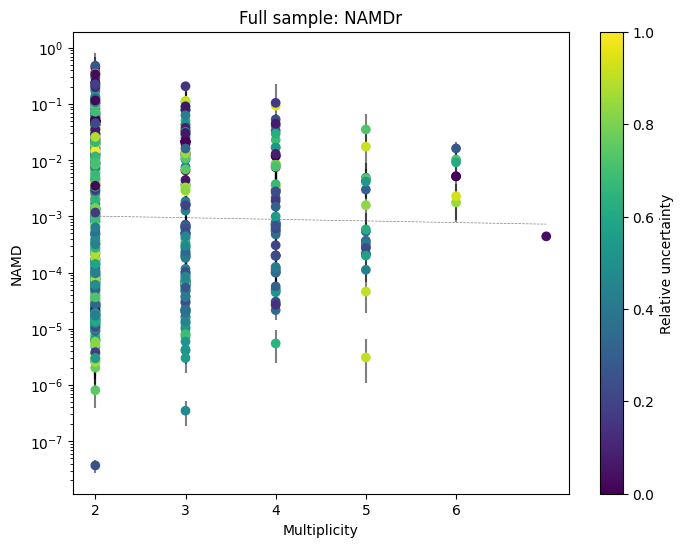

In [25]:
# plot the NAMD vs N and color by the relative uncertainty
namd_relincl_plot = namd_relincl.copy()
namd_relincl_plot.drop(columns=["flag", "hostname"], inplace=True)
# make the whole DataFrame numeric
namd_relincl_plot = namd_relincl_plot.apply(pd.to_numeric)
# sort columns by multiplicity
namd_relincl_plot = namd_relincl_plot.sort_values(by="N")

# plot the NAMD vs N and color by the relative uncertainty
plt.figure(figsize=(8, 6))
plt.errorbar(namd_relincl_plot["N"], namd_relincl_plot["namd"], yerr=[namd_relincl_plot["namd_err2"], namd_relincl_plot["namd_err1"]], fmt="none", c="k", alpha=0.5)
s = plt.scatter(namd_relincl_plot["N"], namd_relincl_plot["namd"], c=namd_relincl_plot["relative_uncertainty"], cmap="viridis", zorder=10)

coeffs = np.polyfit(namd_relincl_plot["N"], np.log10(namd_relincl_plot["namd"]), 1)
plt.plot(namd_relincl_plot["N"], 10 ** np.polyval(coeffs, namd_relincl_plot["N"]), 'k--', zorder=5, alpha=0.5, lw=0.5)
# namd_err_avg = (namd_relincl_plot["namd_err1"] + namd_relincl_plot["namd_err2"]) / 2
# popt, pcov = curve_fit(func, namd_relincl_plot["N"], np.log10(namd_relincl_plot["namd"]), sigma=namd_err_avg/namd_relincl_plot["namd"] * np.log(10), absolute_sigma=True)
# plt.plot(namd_relincl_plot["N"], 10 ** func(namd_relincl_plot["N"], *popt), 'r-', zorder=5, alpha=0.5, lw=0.5)

plt.colorbar(s, label="Relative uncertainty")
plt.clim(0, 1)
plt.xlabel("Multiplicity")
plt.ylabel("NAMD")
plt.yscale("log")
plt.title("Full sample: NAMDr")
plt.xticks(range(2, 7))
plt.savefig("namdr_full_sample.pdf", dpi=300, bbox_inches="tight")
plt.show()

Some plotting

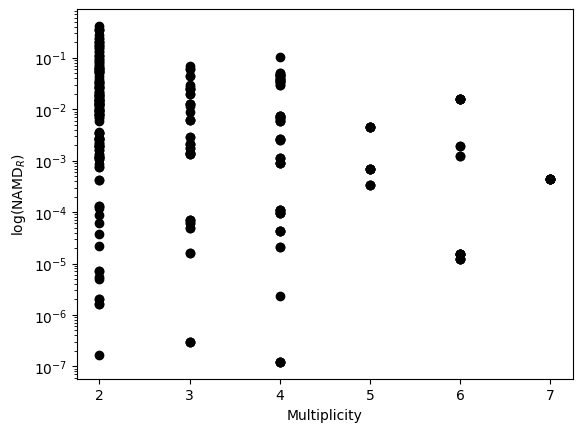

In [26]:
# plot the NAMD vs. multiplicity for all the planets with flag 0
idx = df_clean_relincl["flag"] == "0"
plt.figure()
plt.scatter(df_clean_relincl[idx]["sy_pnum"], df_clean_relincl[idx]["namd"], c="k")
plt.xlabel("Multiplicity")
plt.ylabel("log(NAMD$_R$)")
plt.yscale("log")
plt.grid(False)
plt.show()

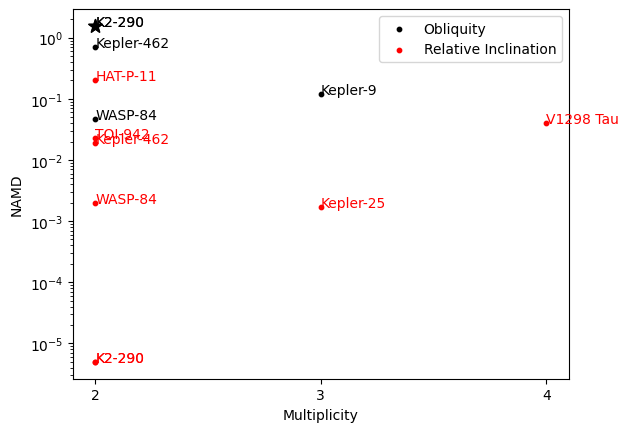

In [27]:
# plot the NAMD vs multiplicity for the planets with obliquity

plt.figure()
idx = df_clean_obliquity["pl_trueobliq"].notnull()
plt.scatter(df_clean_obliquity[idx]["sy_pnum"], df_clean_obliquity[idx]["namd"], c="k", s=10, label="Obliquity")
# write the names of the host stars next to the points
for i, txt in enumerate(df_clean_obliquity[idx]["hostname"]):
    plt.annotate(txt, (df_clean_obliquity[idx]["sy_pnum"].values[i], df_clean_obliquity[idx]["namd"].values[i]), color="k")

# mark with a star the system K2-290
idx = df_clean_obliquity["hostname"] == "K2-290"
plt.scatter(df_clean_obliquity[idx]["sy_pnum"], df_clean_obliquity[idx]["namd"], c="k", s=100, marker="*") #, label="K2-290")

# now for the planets with relative inclination
# trueobliq_notnull = df_clean_relincl["pl_trueobliq"].notnull()
plt.scatter(df_clean_relincl[trueobliq_notnull]["sy_pnum"], df_clean_relincl[trueobliq_notnull]["namd"], c="r", s=10, label="Relative Inclination")

# write the names of the host stars next to the points
for i, txt in enumerate(df_clean_relincl[trueobliq_notnull]["hostname"]):
    plt.annotate(txt, (df_clean_relincl[trueobliq_notnull]["sy_pnum"].values[i], df_clean_relincl[trueobliq_notnull]["namd"].values[i]), color="r")

plt.legend()
plt.xlabel("Multiplicity")
plt.ylabel("NAMD")
plt.yscale("log")
plt.xticks(np.arange(2, 5))
plt.show()

In [28]:
df[df["hostname"] == "Kepler-9"]

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,flag
1799,Kepler-9 c,Kepler-9,1.0,0.22715,0.00650,-0.00450,29.90000,2.96600,-3.21600,3.0,0.0,0.00055,-0.00056,89.38,0.0050,-0.0060,NaN,NaN,NaN,0
1806,Kepler-9 d,Kepler-9,1.0,0.02700,0.00042,-0.00043,8.41466,4.18941,-4.18941,3.0,0.0,0.00000,0.00000,89.38,0.0000,0.0000,NaN,NaN,NaN,01+1-3+3-
1884,Kepler-9 b,Kepler-9,1.0,0.14230,0.00400,-0.00350,43.54100,2.70000,-3.30000,3.0,0.0,0.00100,-0.00130,89.38,0.1335,-0.1325,28.1,13.0,-13.6,0


TOI-942 benchmark

In [29]:
df_clean_relincl[df_clean_relincl["hostname"] == "TOI-942"]

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,...,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,flag,pl_relincl,pl_relinclerr1,pl_relinclerr2,amd,namd
3806,TOI-942 c,TOI-942,1.0,0.08598,0.0012,-0.00110,32.0,0.0,0.0,2.0,...,-0.1315,89.200,0.60,-0.42,02+2-,0.000,0.848528,0.593970,0.144797,0.022573
3805,TOI-942 b,TOI-942,1.0,0.04866,0.0007,-0.00065,16.0,0.0,0.0,2.0,...,-0.1195,89.966,0.34,-0.51,02+2-,-0.766,0.689638,0.660681,0.146677,0.022573


In [30]:
userid = "TOI-942"
toi942_idx = df_clean_relincl[df_clean_relincl["hostname"] == userid].index
df_userid = df_clean_relincl.loc[toi942_idx]

# df.loc[1925, df.columns] = ["TOI-942b", "TOI-942", 0.0498, 0.0007, -0.0007, 21, 4, -4, 2, 0.285, 0.133, -0.099, 88.6, 1.0, -1.0]
# df.loc[1926, df.columns] = ["TOI-942c", "TOI-942", 0.0880, 0.0014, -0.0014, 27, 5, -5, 2, 0.175, 0.139, -0.103, 89.2, 0.6, -0.6]

In [31]:
df_userid.loc[toi942_idx, "pl_orbsmax"] = [0.0880, 0.0498]
df_userid.loc[toi942_idx, "pl_orbsmaxerr1"] = [0.0014, 0.0007]
df_userid.loc[toi942_idx, "pl_orbsmaxerr2"] = [-0.0014, -0.0007]
df_userid.loc[toi942_idx, "pl_bmasse"] = [27.0, 21.0]
df_userid.loc[toi942_idx, "pl_bmasseerr1"] = [5.0, 4.0]
df_userid.loc[toi942_idx, "pl_bmasseerr2"] = [-5.0, -4.0]
df_userid.loc[toi942_idx, "pl_orbeccen"] = [0.175, 0.285]
df_userid.loc[toi942_idx, "pl_orbeccenerr1"] = [0.139, 0.133]
df_userid.loc[toi942_idx, "pl_orbeccenerr2"] = [-0.103, -0.099]
df_userid.loc[toi942_idx, "pl_orbincl"] = [89.2, 88.6]
df_userid.loc[toi942_idx, "pl_orbinclerr1"] = [0.6, 1.0]
df_userid.loc[toi942_idx, "pl_orbinclerr2"] = [-0.6, -1.0]
maxmass_toi942 = df_userid["pl_bmasse"].idxmax()
df_userid.loc[toi942_idx, "pl_relincl"] = df_userid.loc[maxmass_toi942, "pl_orbincl"] - df_userid["pl_orbincl"]
df_userid.loc[toi942_idx, "pl_relinclerr1"] = np.sqrt(df_userid.loc[maxmass_toi942, "pl_orbinclerr1"]**2 + df_userid["pl_orbinclerr1"]**2)
df_userid.loc[toi942_idx, "pl_relinclerr2"] = np.sqrt(df_userid.loc[maxmass_toi942, "pl_orbinclerr2"]**2 + df_userid["pl_orbinclerr2"]**2)

Plotting...


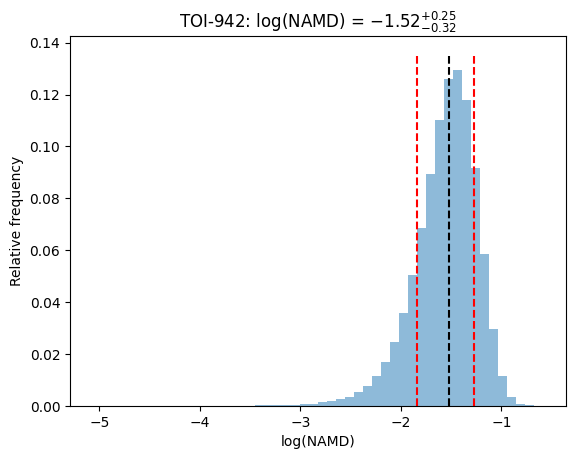

{'q16': 0.0143201905442636,
 'q50': 0.0302479797324671,
 'q84': 0.05385728540263479,
 'N': 2.0}

In [32]:
Npt = 1000000
compute_namd(userid, df_userid, Npt)

In [33]:
df_userid = df_userid[df_userid.columns.drop([
    # "pl_trueobliq", "pl_trueobliqerr1", "pl_trueobliqerr2", 
    "flag", "amd", "namd"])]
df_userid.to_csv("TOI-942.csv")

In [34]:
df_userid.columns

Index(['pl_name', 'hostname', 'default_flag', 'pl_orbsmax', 'pl_orbsmaxerr1',
       'pl_orbsmaxerr2', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2',
       'sy_pnum', 'pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2',
       'pl_orbincl', 'pl_orbinclerr1', 'pl_orbinclerr2', 'pl_relincl',
       'pl_relinclerr1', 'pl_relinclerr2'],
      dtype='object')

K2-290 benchmark

In [35]:
df_k2290 = df_clean_obliquity[df_clean_obliquity["hostname"] == "K2-290"]

In [36]:
df_k2290[["pl_orbincl", "pl_orbinclerr1", "pl_orbinclerr2", "pl_relincl", "pl_relinclerr1", "pl_relinclerr2", "pl_trueobliq", "pl_trueobliqerr1", "pl_trueobliqerr2"]]

,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_relincl,pl_relinclerr1,pl_relinclerr2,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2
16822,88.20,0.50,-0.60,127.0,42.0,-50.0,127.0,42.0,-50.0
1312,89.37,0.08,-0.07,124.0,6.0,-6.0,124.0,6.0,-6.0


In [37]:
Npt = 1000000
userid = "K2-290"

k2290_idx = df_clean_relincl[df_clean_relincl["hostname"] == userid].index
df_userid = df_clean_relincl.loc[k2290_idx]

k2290_namdr = compute_namd(userid, df_userid, Npt, do_plot=False, return_samples=True)

k2290_idx = df_clean_obliquity[df_clean_obliquity["hostname"] == userid].index
df_userid = df_clean_obliquity.loc[k2290_idx]

k2290_namda = compute_namd(userid, df_userid, Npt, do_plot=False, return_samples=True)

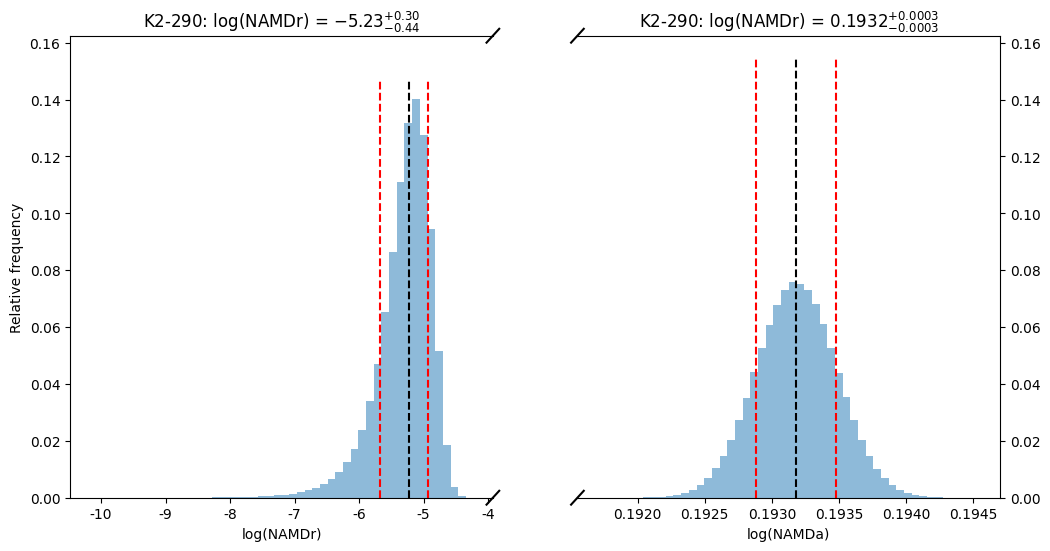

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

log_namd = np.log10(k2290_namdr["samples"]["namd"])
log_quantiles = log_namd.quantile([0.16, 0.5, 0.84])
weights = np.ones_like(log_namd) / len(log_namd)
ax1.hist(log_namd, bins=50, alpha=0.5, weights=weights)
ax1.vlines(log_quantiles, 0, plt.ylim()[1], color=["red", "black", "red"], linestyles="dashed")
ax1.set_ylabel("Relative frequency")
ax1.set_xlabel(rf"log(NAMDr)")
ax1.set_xticks(ax1.get_xticks())
ax1.set_xticklabels(ax1.get_xticks())
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "%.0f" % x))

title = f"{userid}: " + rf"log(NAMDr) = ${log_quantiles[0.5]:.2f}^{{+{log_quantiles[0.84]-log_quantiles[0.5]:.2f}}}_{{-{log_quantiles[0.5]-log_quantiles[0.16]:.2f}}}$"
ax1.set_title(title)

log_namda = np.log10(k2290_namda["samples"]["namd"])
log_quantiles = log_namda.quantile([0.16, 0.5, 0.84])
weights = np.ones_like(log_namda) / len(log_namda)
ax2.hist(log_namda, bins=50, alpha=0.5, weights=weights)
ax2.vlines(log_quantiles, 0, plt.ylim()[1], color=["red", "black", "red"], linestyles="dashed")
ax2.set_xlabel(rf"log(NAMDa)")

title = f"{userid}: " + rf"log(NAMDr) = ${log_quantiles[0.5]:.4f}^{{+{log_quantiles[0.84]-log_quantiles[0.5]:.4f}}}_{{-{log_quantiles[0.5]-log_quantiles[0.16]:.4f}}}$"
ax2.set_title(title)

# hide the spines between ax and ax2
ax2.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.yaxis.tick_left()
ax2.tick_params(labelright="off")
ax2.yaxis.tick_right()

ax2.set_xticks(ax2.get_xticks())
ax2.set_xticklabels(ax2.get_xticks())
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: "%.4f" % x))

d = 0.015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color="k", clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)

plt.savefig("K2-290_namd.pdf", dpi=300, bbox_inches="tight")
plt.show()

trueoblmm_hostnames

In [39]:
df_namd_obliquity_trueoblmm_hostnames = df_clean_obliquity[df_clean_obliquity["hostname"].isin(trueoblmm_hostnames)]

namd_obliquity_trueoblmm_hostnames = namd_loop(df_namd_obliquity_trueoblmm_hostnames)

namd_obliquity_trueoblmm_hostnames

0


,hostname,namd,namd_err1,namd_err2,N,flag,relative_uncertainty
0,Kepler-462,0.696968,0.00888,0.003738,2.0,"[0, 03+3-]",0.009052
1,Kepler-9,0.117878,0.00056,0.000563,3.0,"[01+1-3+3-, 0, 0]",0.004762
2,WASP-84,0.046973,0.000561,0.000549,2.0,"[01, 01+1-]",0.011812


In [40]:
df_namd_relincl_trueoblmm_hostnames = df_clean_relincl[df_clean_relincl["hostname"].isin(trueoblmm_hostnames)]

namd_relincl_trueoblmm_hostnames = namd_loop(df_namd_relincl_trueoblmm_hostnames)

namd_relincl_trueoblmm_hostnames

2


,hostname,namd,namd_err1,namd_err2,N,flag,relative_uncertainty
2,WASP-84,0.001959,0.000556,0.000551,2.0,"[01, 01+1-]",0.282488


In [41]:
df_clean_relincl[df_clean_relincl["hostname"].isin(trueoblmm_hostnames)]

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,...,pl_orbeccenerr2,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,flag,pl_relincl,pl_relinclerr1,pl_relinclerr2,amd,namd
3192,Kepler-462 b,Kepler-462,1.0,0.47310,0.00000,0.00000,53.90000,104.60000,-23.80000,2.0,...,-0.01900,89.340,0.0500,-0.0500,0,0.000,0.070711,0.070711,0.058177,0.018877
4378,Kepler-462 c,Kepler-462,1.0,0.86000,0.00000,0.00000,6.00000,10.80000,-4.90000,2.0,...,-0.09000,90.640,0.0600,-0.0600,03+3-,-1.300,0.078102,0.078102,0.746698,0.018877
1806,Kepler-9 d,Kepler-9,1.0,0.02700,0.00042,-0.00043,8.41466,4.18941,-4.18941,3.0,...,0.00000,89.380,0.0000,0.0000,01+1-3+3-,0.000,0.133500,0.132500,0.000000,0.000000
1799,Kepler-9 c,Kepler-9,1.0,0.22715,0.00650,-0.00450,29.90000,2.96600,-3.21600,3.0,...,-0.00056,89.380,0.0050,-0.0060,0,0.000,0.133594,0.132636,0.000000,0.000000
1884,Kepler-9 b,Kepler-9,1.0,0.14230,0.00400,-0.00350,43.54100,2.70000,-3.30000,3.0,...,-0.00130,89.380,0.1335,-0.1325,0,0.000,0.188798,0.187383,0.000000,0.000000
1724,WASP-84 c,WASP-84,1.0,0.02359,0.00100,-0.00100,15.20000,4.50000,-4.20000,2.0,...,0.00000,83.200,0.5100,-0.4900,01,5.168,0.512445,0.492544,0.124535,0.001959
192,WASP-84 b,WASP-84,1.0,0.07730,0.00145,-0.00145,220.28250,13.03103,-12.71320,2.0,...,0.00000,88.368,0.0500,-0.0500,01+1-,0.000,0.070711,0.070711,0.000000,0.001959


In [42]:
df_clean_obliquity[df_clean_obliquity["hostname"].isin(trueoblmm_hostnames)]

,pl_name,hostname,default_flag,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,sy_pnum,...,pl_orbinclerr2,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,flag,pl_relincl,pl_relinclerr1,pl_relinclerr2,amd,namd
3192,Kepler-462 b,Kepler-462,1.0,0.47310,0.00000,0.00000,53.90000,104.60000,-23.80000,2.0,...,-0.0500,72.0,3.0,-3.0,0,72.0,3.0,-3.0,25.635234,0.696807
4378,Kepler-462 c,Kepler-462,1.0,0.86000,0.00000,0.00000,6.00000,10.80000,-4.90000,2.0,...,-0.0600,NaN,NaN,NaN,03+3-,72.0,3.0,-3.0,4.075107,0.696807
1806,Kepler-9 d,Kepler-9,1.0,0.02700,0.00042,-0.00043,8.41466,4.18941,-4.18941,3.0,...,0.0000,NaN,NaN,NaN,01+1-3+3-,28.1,13.0,-13.6,0.162980,0.117873
1799,Kepler-9 c,Kepler-9,1.0,0.22715,0.00650,-0.00450,29.90000,2.96600,-3.21600,3.0,...,-0.0060,NaN,NaN,NaN,0,28.1,13.0,-13.6,1.679741,0.117873
1884,Kepler-9 b,Kepler-9,1.0,0.14230,0.00400,-0.00350,43.54100,2.70000,-3.30000,3.0,...,-0.1325,28.1,13.0,-13.6,0,28.1,13.0,-13.6,1.936046,0.117873
1724,WASP-84 c,WASP-84,1.0,0.02359,0.00100,-0.00100,15.20000,4.50000,-4.20000,2.0,...,-0.4900,NaN,NaN,NaN,01,17.3,7.7,-7.7,0.215903,0.046974
192,WASP-84 b,WASP-84,1.0,0.07730,0.00145,-0.00145,220.28250,13.03103,-12.71320,2.0,...,-0.0500,17.3,7.7,-7.7,01+1-,17.3,7.7,-7.7,2.770669,0.046974


In [43]:
namd

<function core.namd(amd: <built-in function array>, m: <built-in function array>, a: <built-in function array>) -> float>